# 1- Raster data processing


GeoTIFF and other raster formats are commonly used to organize and store gridded raster datasets such as satellite imagery, land use/cover data and terrain models, etc. 

``Rasterio`` is a useful library for reading and writing these formats and provides a Python API based on ``Numpy ``N-dimensional arrays and GeoJSON. Before ``Rasterio`` there was one Python option for accessing the many different kind of raster data files used in the GIS field: the Python bindings distributed with the Geospatial Data Abstraction Library, ``GDAL``. 


In this exercise, we will be reading a raster file of ``africa.tif``, which contains population data and urban settlements, and doing some common processes on it. Lets' import a couple of libraries that will be using:

In [1]:
import rasterio        # for reading raster data
import bokeh           # for data visualization 
import urllib.request  # for reading data from a URL
import zipfile         # for dealing with zip files
import os              # interacting with the operating system 

Download and a multi-layer GeoTIFF, but **only** if it hasn't been downloaded and unzipped before:

In [2]:
# a backup command if you have the data zipped somewhere, otherwise skip this cell

if os.path.isfile('Data/Africa.tif'):
    print("Africa.tif already downloaded and unzipped.")
else:
    urllib.request.urlretrieve("https://uc1bff32cda2cc90030c822555b3.dl.dropboxusercontent.com/cd/0/get/Cpj9Z3wJr7XeMu-FjpIKbRaSsjSxG9vEOd2bVof7ov3KZmCcCrGuTojm-bbA8SE0XMciZBZzZsTqFS09pyHH58lSJAyzvYP6SfuJ67yxsOi55N47Bn9Y3i6qyjh4utWs1Qn-7Z2FxVobMr2W5negtCtWjwefoH2YaYTDmC9UB3txhQ/file?_download_id=3581938782105742574477377492174284739551155259497013143859056841234&_log_download_success=1&_notify_domain=www.dropbox.com&dl=1", "Africa.zip")
    zf = zipfile.ZipFile("Africa.zip")
    zf.extractall()
    zf.close()
    os.remove("Africa.zip") # clean up
    print("Download and unzip complete.")

Africa.tif already downloaded and unzipped.


In [3]:
if os.path.isfile('Data/Africa.tif'):
    print("Africa.tif already in the current working directory(cwd).")
else:
    print("the file can not be found.")

Africa.tif already in the current working directory(cwd).


Let's open the file with rasterio:

In [4]:
africa_tif = rasterio.open('Data/Africa.tif')

Print some metadata of the dataset:

In [5]:
print("The file is called", africa_tif.name, "\n")
print("It contains", africa_tif.width, "x",africa_tif.height,"pixels")
print()
print("It covers the following extent:",africa_tif.bounds)
print()
print("It is in the following CRS:",africa_tif.crs)

The file is called Data/Africa.tif 

It contains 10663 x 10117 pixels

It covers the following extent: BoundingBox(left=-25.360422329999892, bottom=-46.96575286299996, right=63.493907097000005, top=37.34520091400016)

It is in the following CRS: EPSG:4326


In [6]:
# what is the pixel size of the raster ?
pixelSizeX, pixelSizeY  = africa_tif.res
print (pixelSizeX)
print (pixelSizeY)
# what is the unit?
print ('The pixel size is roughly' ,pixelSizeX*110000, 'meters')

0.008332957838038066
0.008333592347237335
The pixel size is roughly 916.6253621841873 meters


How many layers are there in this GeoTIFF, and what data types do they use?

In [7]:
{i: dtype for i, dtype in zip(africa_tif.indexes, africa_tif.dtypes)}

{1: 'int16', 2: 'int16', 3: 'int16', 4: 'int16'}

Let's take a look at the layers:

In [8]:
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

Duplicate key in file '/Users/jamal/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')
Duplicate key in file '/Users/jamal/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')
Duplicate key in file '/Users/jamal/.matplotlib/matplotlibrc', line 4 ('backend: TkAgg')


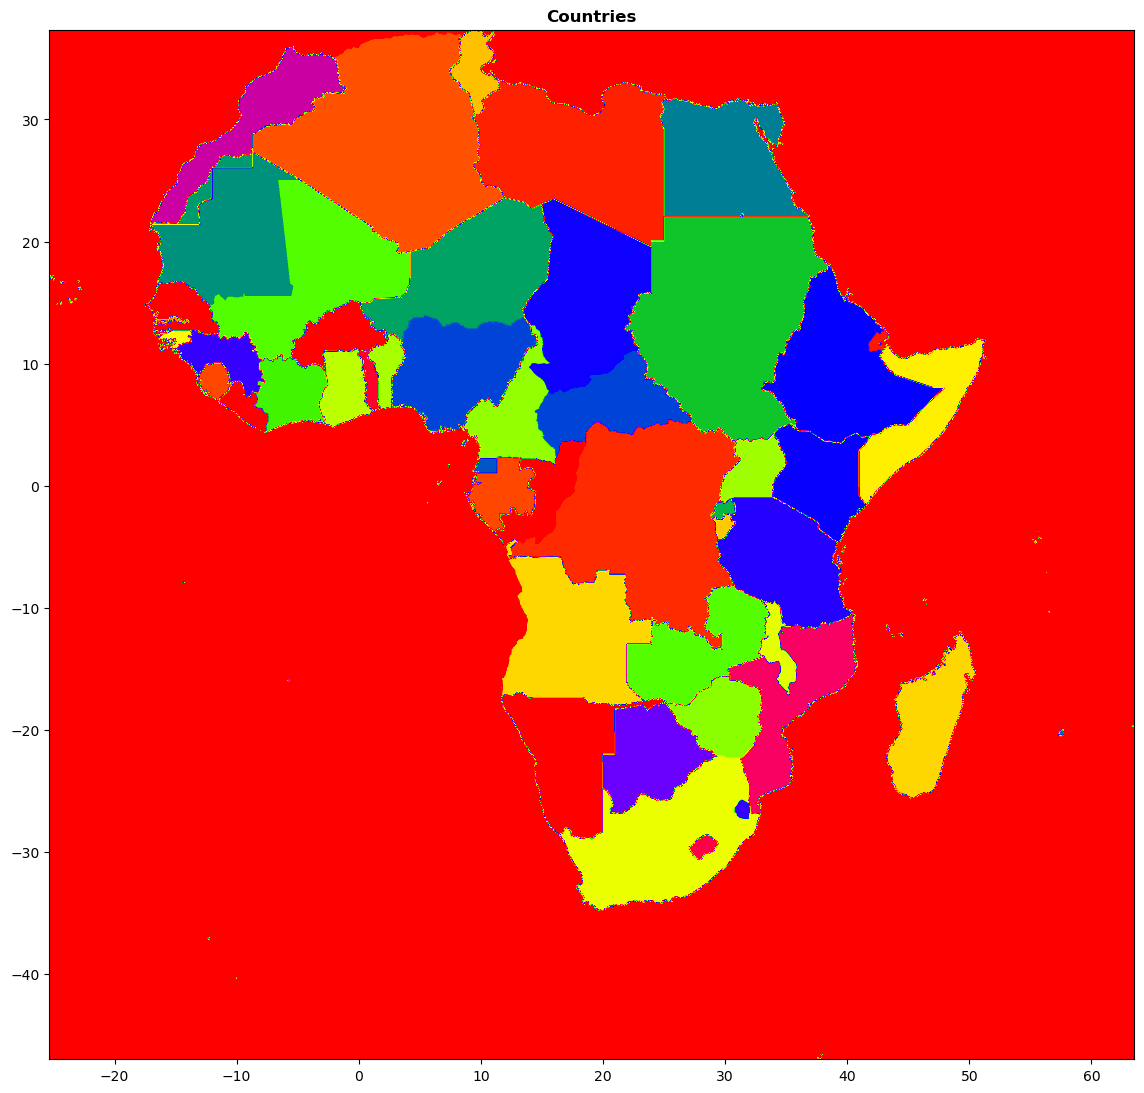

<Axes: title={'center': 'Countries'}>

In [9]:
plt.figure(figsize=(14, 14))
# remember the file has 4 raster layers (countries, Urban, population, )

show((africa_tif, 1), title='Countries', cmap='prism') # reading the first layer, hence layer indexed 1 is shown

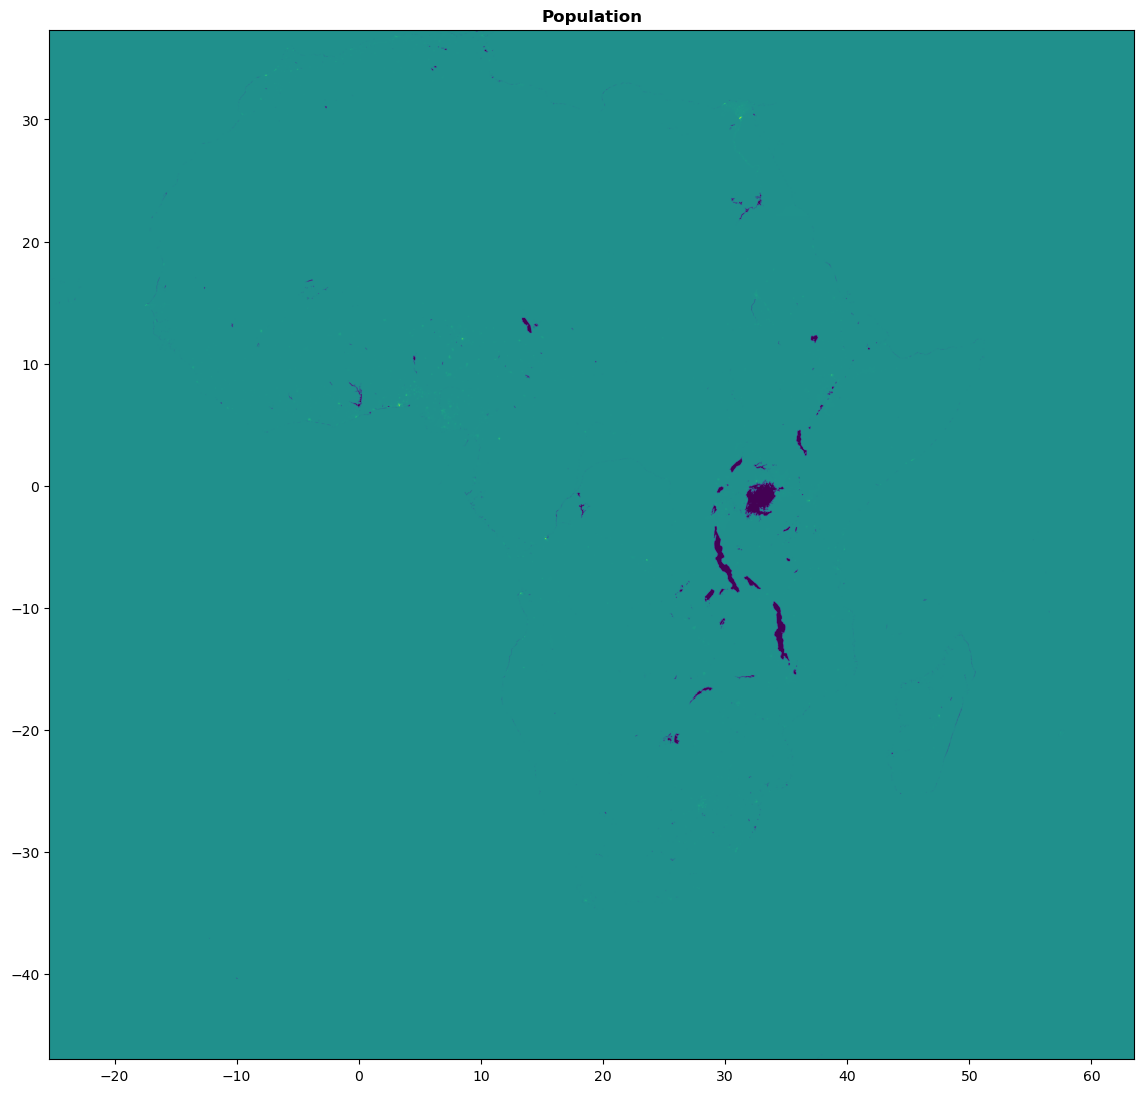

<Axes: title={'center': 'Population'}>

In [10]:
plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population')

Not great, let's try to improve this:

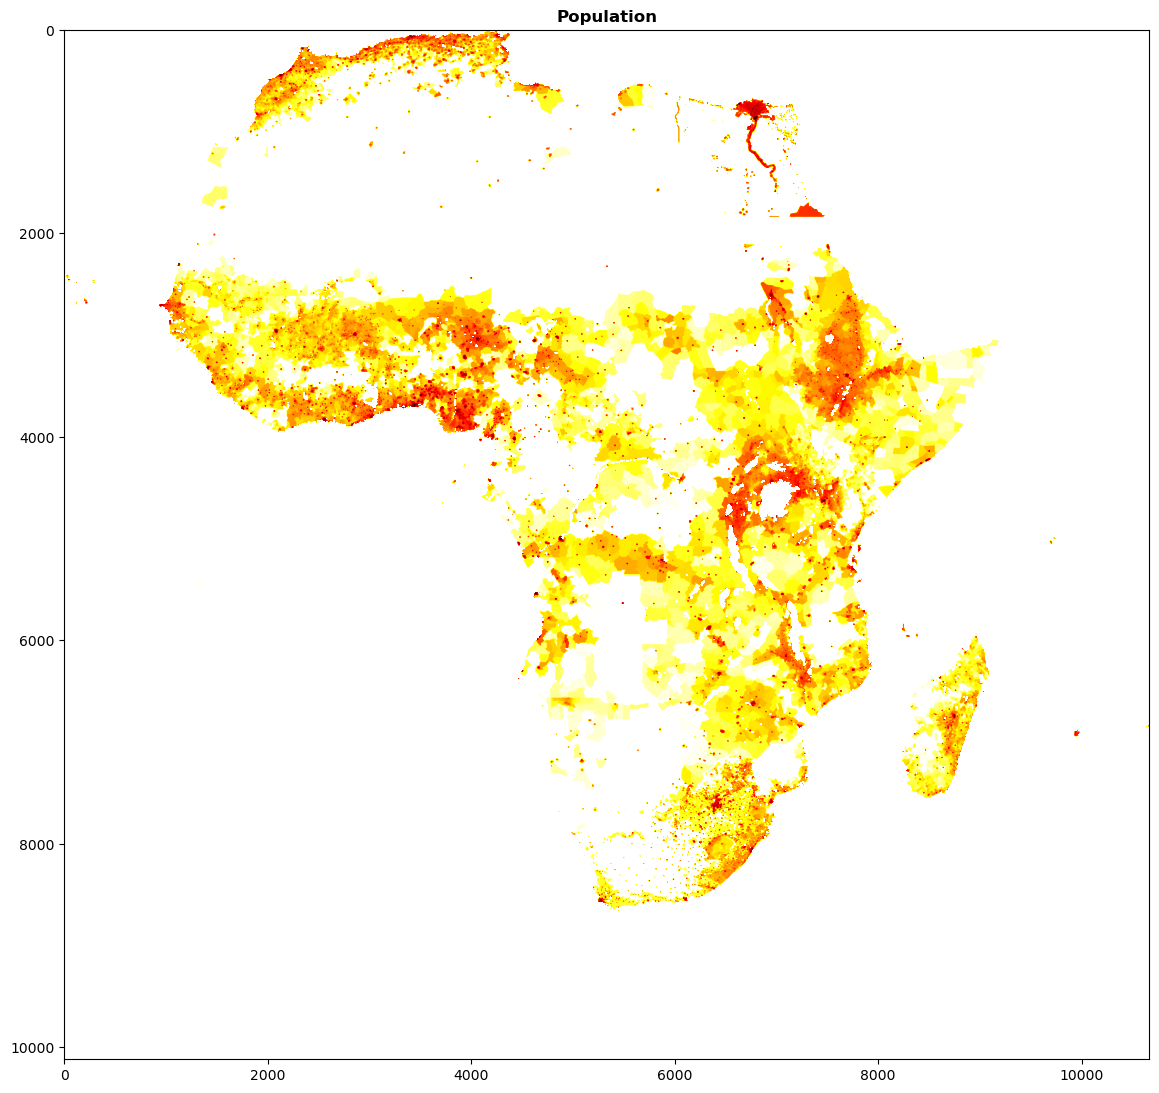

<Axes: title={'center': 'Population'}>

In [11]:
from matplotlib.colors import LogNorm

pop = africa_tif.read(2)  # reading the layer 2 and putting into POP variable

plt.figure(figsize=(14, 14))
show(pop, title='Population', norm=LogNorm(), cmap='hot_r')

Can we add a legend?

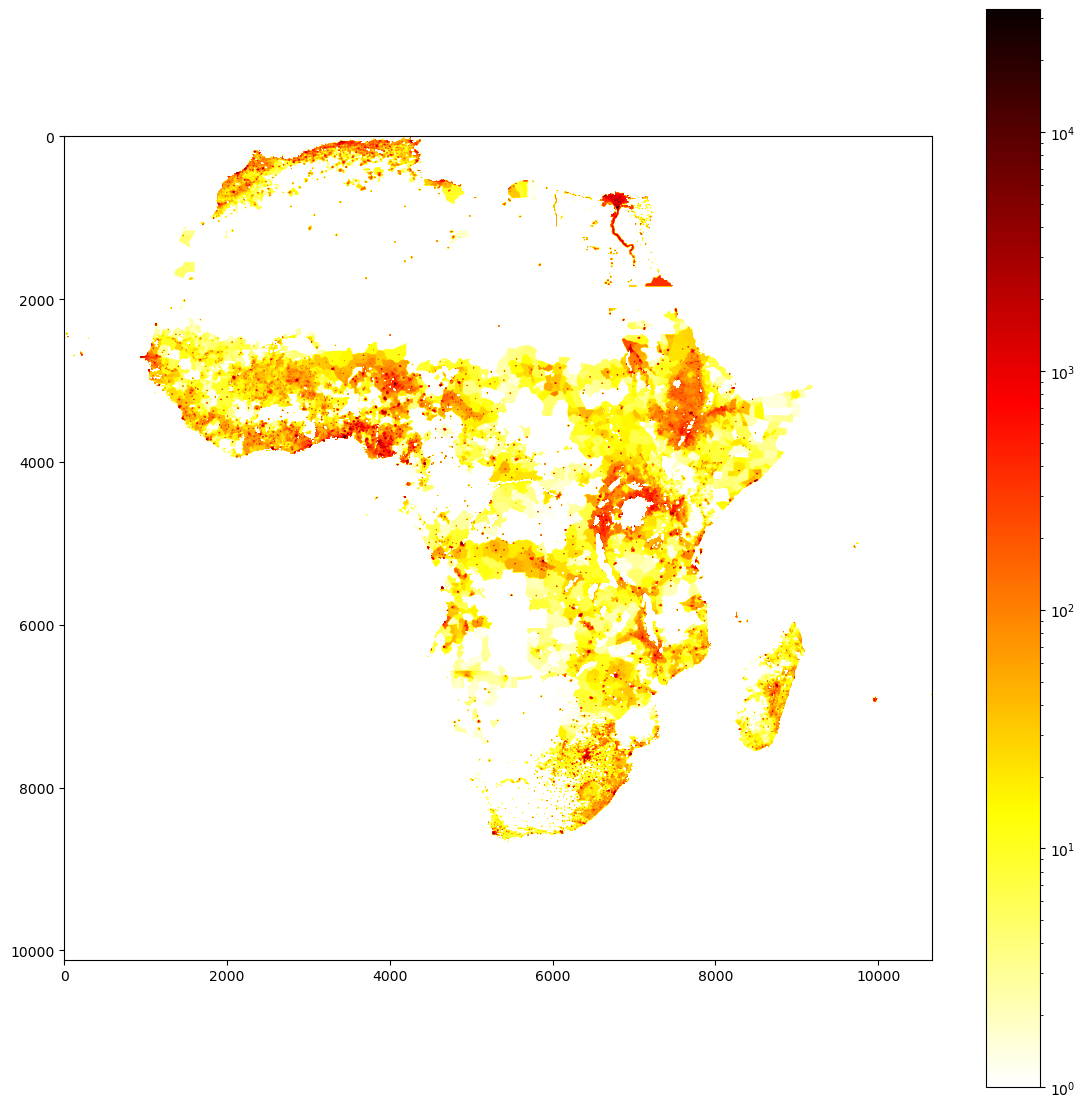

In [12]:
plt.figure(figsize=(14, 14))

imgplot = plt.imshow(pop, norm=LogNorm(), cmap='hot_r')
plt.colorbar() # adding the legend

Alternative: Interactive plots with Bokeh:

Bokeh is a charting tool: it lets you create interactive web charts in Python and automatically displays them in the browser through its BokehJS library in JavaScript.

In [13]:
import numpy as np
import bokeh.plotting as bkplt

In [14]:
pop.shape

(10117, 10663)

In [15]:
p = bkplt.figure(x_range=(0, pop.shape[0]), y_range=(0, pop.shape[1]))

# must give a vector of image data for image parameter
p.image(image=[pop], x=0, y=0, dw=pop.shape[0], dh=pop.shape[1], palette="Spectral11")

bkplt.show(p)

explore [holoviews](https://towardsdatascience.com/displaying-a-gridded-dataset-on-a-web-based-map-ad6bbe90247f) for better interactive maps

# 2- Raster File Compression

The size of raster files can sometimes become very large. Most of computational/modelling/simulation tasks as well as satellite data are large and storing/processing//transfering them can save up a lot time and pain in your code of even softwares. So compressing them can substantially reduce the disk space usage of them.

``LZW`` is one of the compression methods that we will apply below using a function.

In [16]:
def compress(inputfile, outputfile, layer, compression, datatype):
    
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)

        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

In [17]:
# let's try and compress the population dataset and compare it against no compression 
compress(africa_tif, 'pop-float.tif',     pop, None, rasterio.float32)
compress(africa_tif, 'pop-float-lzw.tif', pop, 'lzw', rasterio.float32)
compress(africa_tif, 'pop-int-lzw.tif',   pop, 'lzw', rasterio.int32)

In [18]:
# perhaps an easier way of calling metadata of your raster file
africa_tif.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 10663, 'height': 10117, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008332957838038066, 0.0, -25.360422329999892,
       0.0, -0.008333592347237335, 37.34520091400016), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

Let's do the urban layer to test int8:

In [19]:
urban = africa_tif.read(3)
compress(africa_tif, 'urban-int-lzw.tif', urban, 'lzw', rasterio.int8)

In [20]:
# let's see what are the values in URBAN layer
classes = list(np.unique(urban).astype('int'))
classes

[0, 1, 2]

check the volume of the pop file before and after compression

# 3.Map Algebra [Raster Math]

Map algebra basically involves doing math with maps. But the key difference is that it only applies to raster data. That’s why we also call it raster math. More about it at [here](https://gisgeography.com/map-algebra-global-zonal-focal-local/)

In [21]:
import seaborn as sns     
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

Let's define two layers in the form of ``numpy`` arrays, let's say one is ground elevation, the other one is the height of vegeation above ground:


In [22]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

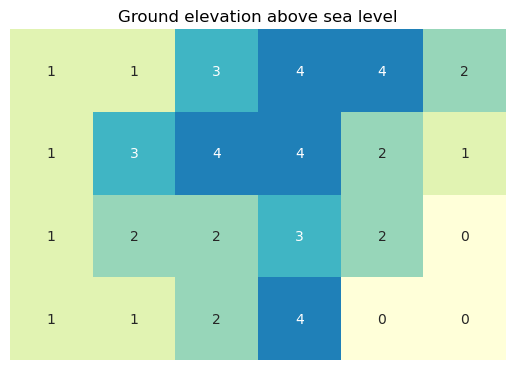

In [23]:
fig = sns.heatmap(elevation, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sea level')

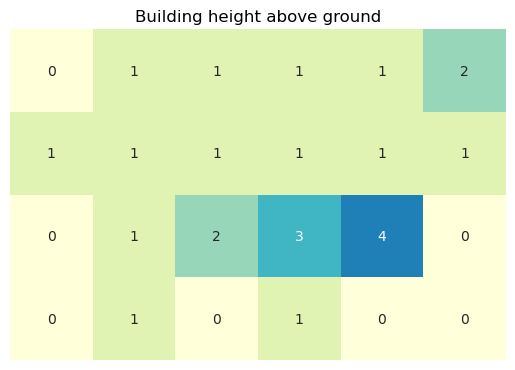

In [24]:
fig = sns.heatmap(building, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')

### 1. Local operation: Calculate building height above sea level

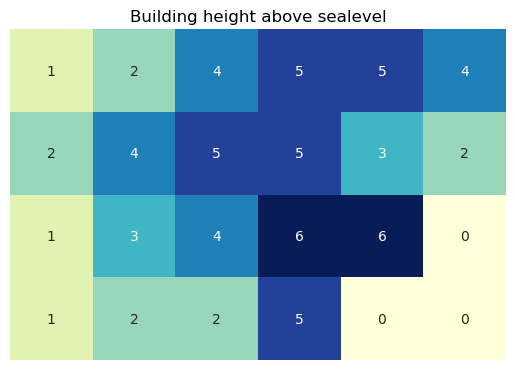

In [25]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')

### 2. Focal operation: Fix errors in elevation raster

Let's assume our elevation raster has a measurement error, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value : (we are manipulating the dataset to embed that in the file)

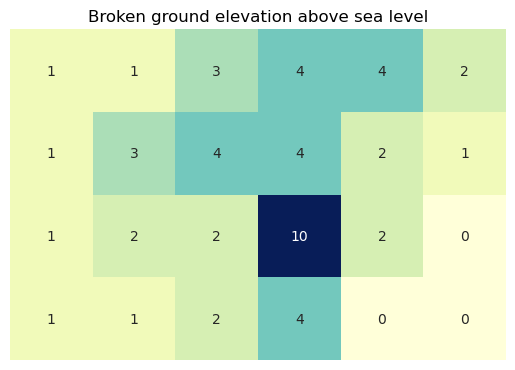

In [26]:
broken_elevation = elevation
broken_elevation[2,3] = 10 # replacing the element 2,3 (row 2 and column 3, note we start counting from 0 and from top-left as source) of the array into 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sea level')

We'll fix this by running a 3x3 window/kernel over it that sets every pixel to the average of its 8 neighbors:

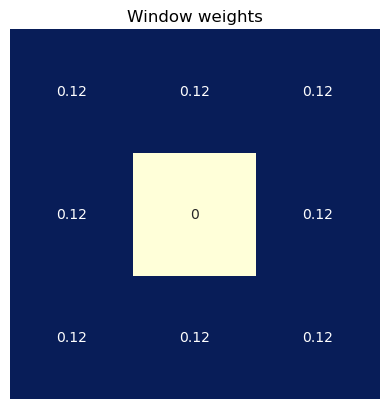

In [27]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])


fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Window weights')

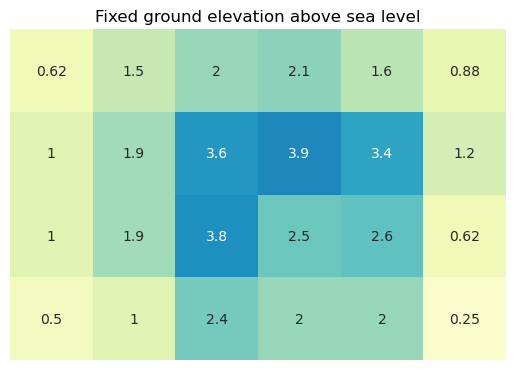

In [28]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sea level')

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

## 3. Zonal operation: Average building height per zone

Let's define two zones (two different land cover types) and calculate the average building height per zone:

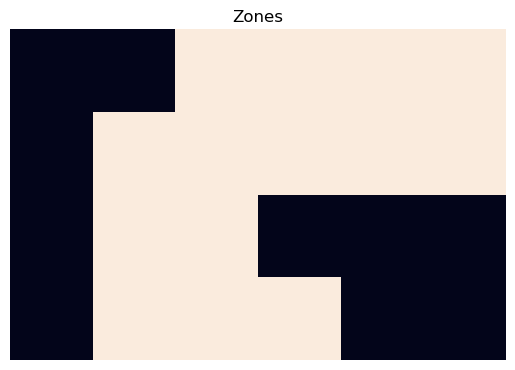

In [29]:
# making the two zones using a numpy array
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')

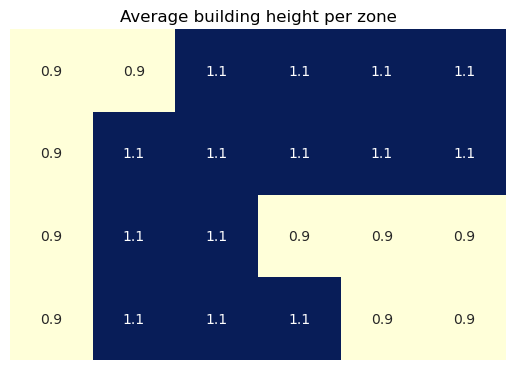

In [30]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
                  cbar=False).set_title('Average building height per zone')

EXERCISE::: how about the average elevation per zone?

How about the the min and max building and elevation values?

## 4. Global operation: Cost distance

We'll use our elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.

### What is a cost surface?

A cost surface, or cost grid, is a raster grid in which the value in each cell is the cost that a particular activity or object would be in that cell. It can also be an indexed value based on costliness. Costs could be measured monetarily or in other ways such as amount of time. A cost surface includes the cost of reaching certain cells from one or more source cells.

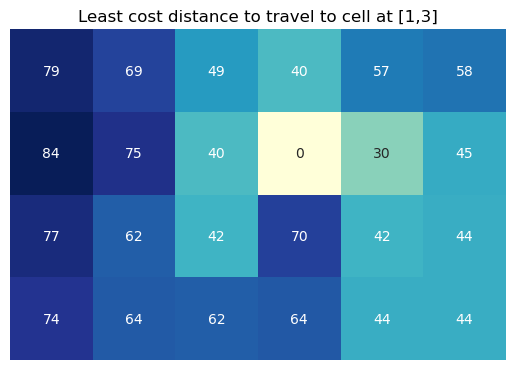

In [69]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [32]:
from skimage.graph import route_through_array

In [33]:
route_through_array(elevation, [3, 5], [1, 3])

([(3, 5), (2, 5), (1, 4), (1, 3)], 4.414213562373095)

In [ ]:
#avg_elevation = np.copy(zones).astype(float)

#for zone in np.unique(zones):
#    avg_elevation[zones == zone] = np.mean(elevation[zones == zone])
    
#fig = sns.heatmap(avg_elevation, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
#                  cbar=False).set_title('Average elevation height per zone')